In [1]:
import os, glob
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
IMG_SIZE = 128
DATA_PATH = "./Data/Scores"

In [3]:
paths, labels = [], []

for shape_name in os.listdir(DATA_PATH):
    shape_path = os.path.join(DATA_PATH, shape_name)
    if not os.path.isdir(shape_path):
        continue
    for score in os.listdir(shape_path):
        score_path = os.path.join(shape_path, score)
        if not os.path.isdir(score_path):
            continue
        label = f"{shape_name}_{score}"
        for ext in ("*.png", "*.jpg", "*.jpeg"):
            for p in glob.glob(os.path.join(score_path, ext)):
                paths.append(p)
                labels.append(label)

df = pd.DataFrame({"path": paths, "label": labels})
print("[INFO] Dataset size:", len(df))

[INFO] Dataset size: 4297


In [4]:
def extract_features(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # HOG features
    hog_feats = hog(img, orientations=9, pixels_per_cell=(8,8),
                    cells_per_block=(2,2), block_norm='L2-Hys', feature_vector=True)
    
    # Hu Moments
    moments = cv2.moments(img)
    hu_feats = cv2.HuMoments(moments).flatten()
    
    # Area
    area = [np.sum(img) / 255.0]
    
    return np.hstack([hog_feats, hu_feats, area])

print("[INFO] Extracting features...")
features = [extract_features(p) for p in df['path']]
X = np.vstack(features)
y_labels = np.array(df['label'])

[INFO] Extracting features...


In [5]:
le = LabelEncoder()
y = le.fit_transform(y_labels)

In [6]:
counts = Counter(y)
mask = np.array([counts[label] > 1 for label in y])
X = X[mask]
y = y[mask]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [8]:
print("[INFO] Training Random Forest...")
rf = RandomForestClassifier(
    n_estimators=200,   # number of trees
    max_depth=None,     # allow trees to expand fully
    random_state=42,
    class_weight="balanced"  # handles class imbalance
)
rf.fit(X_train, y_train)

[INFO] Training Random Forest...


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [9]:
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

print(classification_report(
    y_test, y_pred,
    labels=np.unique(y_test),
    target_names=le.classes_[np.unique(y_test)]
))

Test Accuracy: 0.7276
                      precision    recall  f1-score   support

            Circle_0       0.00      0.00      0.00         1
            Circle_3       0.00      0.00      0.00        22
            Circle_4       0.74      0.95      0.83        91
          Diagonal_0       0.00      0.00      0.00         1
          Diagonal_4       0.00      0.00      0.00        14
          Diagonal_5       0.78      0.98      0.87        96
 Overlapped circle_0       0.00      0.00      0.00         1
 Overlapped circle_4       0.00      0.00      0.00         2
 Overlapped circle_5       0.00      0.00      0.00        27
 Overlapped circle_6       0.67      0.91      0.77        77
Overlapped pencils_0       0.00      0.00      0.00         2
Overlapped pencils_3       0.00      0.00      0.00         2
Overlapped pencils_4       0.00      0.00      0.00        11
Overlapped pencils_5       0.50      0.14      0.22        29
Overlapped pencils_6       0.54      0.82      

/home/mahabur-alam/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mahabur-alam/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mahabur-alam/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

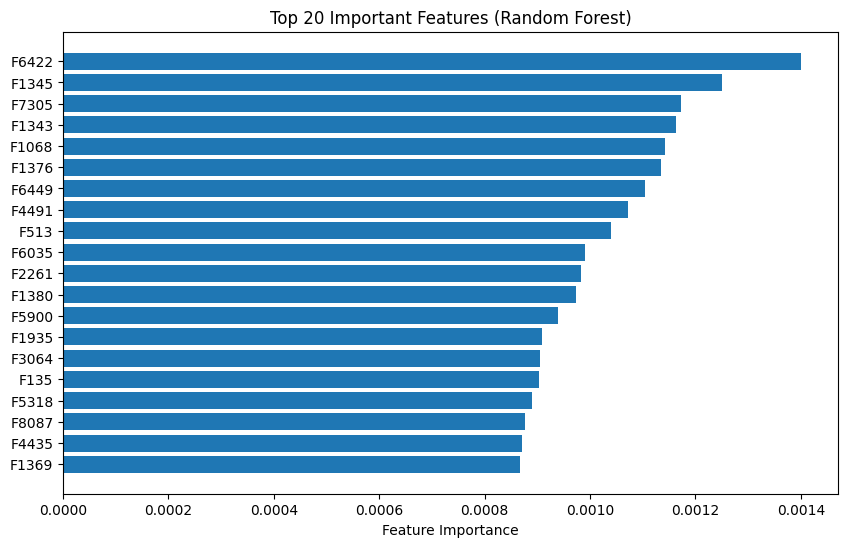

In [10]:
importances = rf.feature_importances_
indices = np.argsort(importances)[-20:]  # top 20 features

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [f"F{i}" for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 20 Important Features (Random Forest)")
plt.show()